In [1]:
import os, json, time
import numpy as np
import pandas as pd
import shap
import joblib
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

### Modelo MLP Base

In [7]:
VERSION_TAG_MLP = "v1" 
BASE_MLP = "models"
SEED = 42
TOPK = 20
BG_K = 256 # k-means prototypes para background
EX_N = 512 # filas a explicar

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

In [8]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [9]:
# === Datos ===
DF = df_base.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [10]:
# Parámetros (puedes ajustar)
TOPK = 20
BG_K = min(128, X_std.shape[0])              # prototipos k-means para background
EX_N = min(256, X_std.shape[0])              # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=791.42s

[MLP] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.453567   0.369003
               banos    +     0.171056   0.140671
   flag_Departamento    +     0.162424   0.046292
     estacionamiento    +     0.088814   0.060454
       flag_Semipiso    -     0.070568  -0.033808
             terraza    +     0.045335   0.034256
         dormitorios    -     0.039164  -0.024693
             bodegas    +     0.034115   0.024613
     flag_Multinivel    +     0.029507   0.012943
          antiguedad    +     0.023183   0.013997
        flag_Premium    +     0.021084   0.007500
      banos_faltante    +     0.018216   0.014336
                Or_O    -     0.014687  -0.000632
                Or_E    +     0.013578   0.008377
   flag_Monoambiente    -     0.012370  -0.010956
         Or_Faltante    -     0.009516  -0.004890
           flag_Loft    -  

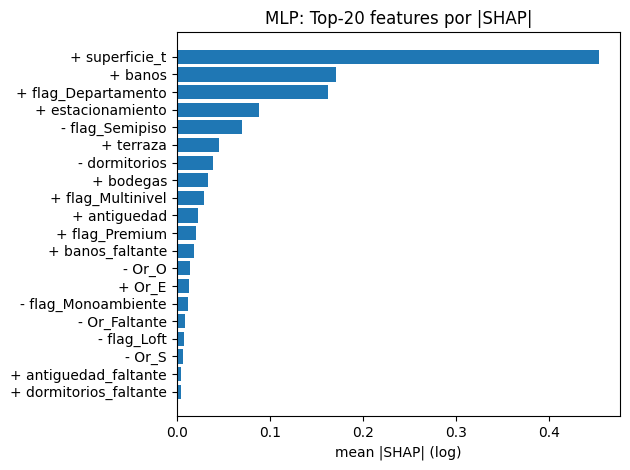

In [11]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con coordenadas MLP

In [12]:
VERSION_TAG_MLP = "v2" 
BASE_MLP = "models"
SEED = 42
TOPK = 20
BG_K = 256 # k-means prototypes para background
EX_N = 512 # filas a explicar

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

#Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

In [13]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [14]:
# === Datos ===
DF = df_coord.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [15]:
# Parámetros (puedes ajustar)
TOPK = 20
BG_K = min(128, X_std.shape[0])              # prototipos k-means para background
EX_N = min(256, X_std.shape[0])              # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=796.36s

[MLP] Top-20 features por |SHAP| con signo:
             feature sign  mean_|shap|  mean_shap
        superficie_t    +     0.390890   0.327201
            longitud    +     0.232949   0.217453
             latitud    +     0.128362   0.124201
               banos    +     0.104652   0.091709
     estacionamiento    +     0.066601   0.056652
          antiguedad    +     0.032007   0.003542
   flag_Departamento    +     0.029557   0.012451
             terraza    +     0.024709   0.008998
             bodegas    +     0.012106   0.009718
         Or_Faltante    -     0.009254  -0.002345
        flag_Premium    +     0.008702   0.006606
       flag_Semipiso    +     0.008689   0.003604
         dormitorios    -     0.008675  -0.000856
      banos_faltante    +     0.007363   0.005692
                Or_O    +     0.005890   0.001749
     flag_Multinivel    +     0.005427   0.004692
                Or_S    +  

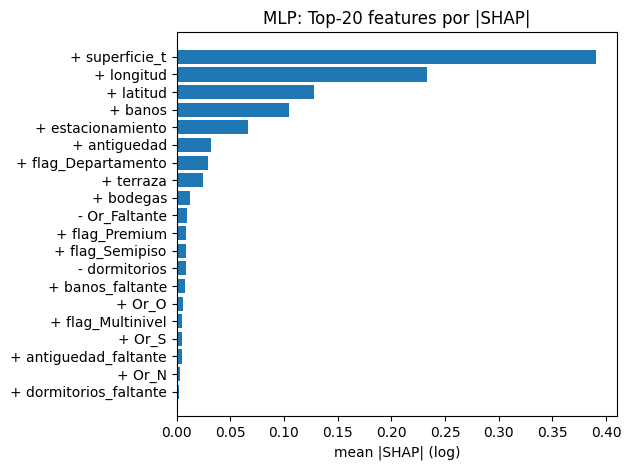

In [16]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()

### Modelo con VCR MLP

In [17]:
VERSION_TAG_MLP = "v3" 
BASE_MLP = "models"
SEED = 42
TOPK = 20
BG_K = 256 # k-means prototypes para background
EX_N = 512 # filas a explicar

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)

# Imputación datos faltantes en VCR
import re
from typing import Dict, Tuple, Optional

# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [18]:
# === Cargar artefactos ===
model = keras.models.load_model(os.path.join(BASE_MLP, f"best_model_mlp_{VERSION_TAG_MLP}.keras"))
scaler = joblib.load(os.path.join(BASE_MLP, f"scaler_mlp_{VERSION_TAG_MLP}.joblib"))
with open(os.path.join(BASE_MLP, f"feature_names_mlp_{VERSION_TAG_MLP}.json"), "r") as f:
    feature_names = json.load(f)

In [19]:
# === Datos ===
DF = df_vcr_imp.copy()
X = DF[feature_names].values.astype(np.float32)
X_std = scaler.transform(X).astype(np.float32)

In [20]:
# Parámetros (puedes ajustar)
TOPK = 20
BG_K = min(128, X_std.shape[0])              # prototipos k-means para background
EX_N = min(256, X_std.shape[0])              # filas a explicar
NSAMPLES = 256  # estabilidad numérica (evita matrices singulares)

# Background representativo (k-means sobre X_std)
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background_np = np.asarray(background, dtype=np.float32)

# Subconjunto a explicar
explain_X = X_std[:EX_N].astype(np.float32)

# Sanidad
assert background_np.ndim == 2 and explain_X.ndim == 2, "background/explain_X deben ser 2D"

# Explainer (modelo Keras)
t0 = time.perf_counter()
f_pred = lambda z: model.predict(z, verbose=0).ravel()
explainer = shap.KernelExplainer(f_pred, background_np, link="identity")
sv = explainer.shap_values(explain_X, nsamples=NSAMPLES)
shap_vals = sv[0] if isinstance(sv, list) else sv
shap_vals = np.asarray(shap_vals, dtype=np.float32)

# Normalizar forma a (n_samples, n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(-1, 1)
if shap_vals.shape[0] != explain_X.shape[0] and shap_vals.shape[1] == explain_X.shape[0]:
    shap_vals = shap_vals.T

print(
    f"[SHAP-MLP] backend=kernel | bg_n={background_np.shape[0]} | "
    f"ex_n={explain_X.shape[0]} | nsamples={NSAMPLES} | time={time.perf_counter()-t0:.2f}s"
)

# Importancias (valor absoluto) y signo (dirección promedio del efecto)
mean_shap = np.mean(shap_vals, axis=0)
imp = np.mean(np.abs(shap_vals), axis=0)
order = np.argsort(imp)[::-1]
sign_char = np.where(mean_shap >= 0, "+", "-")

# Top-K
TOPK = min(TOPK, len(feature_names))
shap_top_mlp = pd.DataFrame({
    "feature": np.array(feature_names)[order][:TOPK],
    "sign": sign_char[order][:TOPK],
    "mean_|shap|": imp[order][:TOPK],
    "mean_shap": mean_shap[order][:TOPK],  # magnitud firmada (opcional)
})

print("\n[MLP] Top-20 features por |SHAP| con signo:")
print(shap_top_mlp.to_string(index=False))

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

[SHAP-MLP] backend=kernel | bg_n=128 | ex_n=256 | nsamples=256 | time=814.57s

[MLP] Top-20 features por |SHAP| con signo:
                     feature sign  mean_|shap|  mean_shap
                superficie_t    +     0.317716   0.267825
                     latitud    +     0.102684   0.100913
                       banos    +     0.091499   0.082315
                    longitud    +     0.076882   0.072457
             estacionamiento    +     0.041165   0.036079
     sport_and_leisure_dim00    +     0.037137   0.037137
     sport_and_leisure_dim08    +     0.029645   0.029645
     sport_and_leisure_dim03    +     0.024535   0.023496
                  antiguedad    +     0.016215   0.015424
              banos_faltante    +     0.010049   0.010049
              security_dim02    +     0.009178   0.008197
                 dormitorios    +     0.006667   0.002722
              security_dim11    +     0.006562   0.006562
                has_security    +     0.005657   0.005033
arts_an

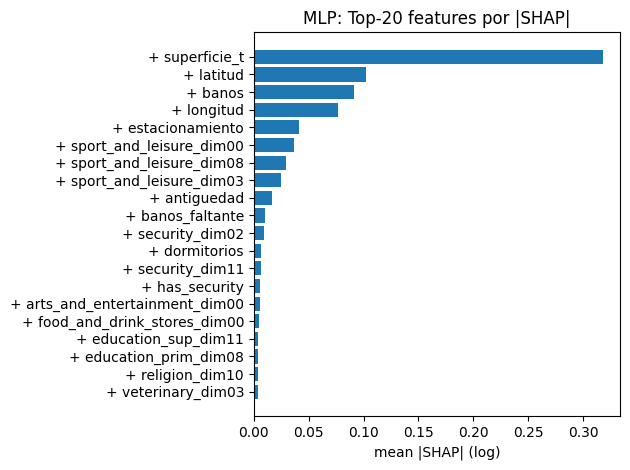

In [21]:
top = shap_top_mlp.copy()  # columnas: feature, sign, mean_|shap|, mean_shap
labels = (top["sign"] + " " + top["feature"]).iloc[::-1]

plt.figure()
plt.barh(labels, top["mean_|shap|"].iloc[::-1])
plt.xlabel("mean |SHAP| (log)")
plt.title("MLP: Top-20 features por |SHAP|")
plt.tight_layout()
plt.show()